In [1]:
import os
import rasterio
import numpy as np
from matplotlib import pyplot as plt

home_path = '/home/jovyan/project/GEO/'
feature_path = '/home/jovyan/project/GEO/Images/'
target_path = '/home/jovyan/project/GEO/Target/'

In [2]:
images = os.listdir(feature_path)

if ('.ipynb_checkpoints' in images):
    images.remove('.ipynb_checkpoints')

target = rasterio.open(os.path.join(target_path, "LC100_2015_global_v2.0.2_discrete-classification_EU010M_E045N021T1.tif"))
target = target.read().squeeze().astype('double')
# Extract annotation range according to water bodies, i.e. between 80 and 200
target[~np.isin(target, [80,200])] = 0
target[np.isin(target, [80,200])] = 1

In [3]:
# Function to cut out larger rectangles for validation/testing purposes

def getPatchOfImage(topLeftIndex, height, width, patchesPerAxes):
    res = []
    for h in range(0, height):
        for w in range(0, width):
            res.append(topLeftIndex + patchesPerAxes * h + w)
    return(np.asarray(res))  

In [4]:
def calc_patches(images, mode = "train", input_size = 10000, patch_size = 256, overlap = 24):

    patchesPerAxes = int((input_size-patch_size)/(patch_size-overlap))+int(1)
    n_patches = patchesPerAxes*patchesPerAxes
    
    # Indices represent the 1849 patches, now assigned to specific sets
    indices = np.arange(n_patches)

    valid_indices = np.concatenate((getPatchOfImage((patchesPerAxes*15)+3, 4, 4, patchesPerAxes),
                                    getPatchOfImage((patchesPerAxes*28)+4, 4, 4, patchesPerAxes),
                                    getPatchOfImage((patchesPerAxes*15)+20, 4, 4, patchesPerAxes),
                                    getPatchOfImage((patchesPerAxes*2)+20, 4, 4, patchesPerAxes),
                                    getPatchOfImage((patchesPerAxes*2)+34, 4, 4, patchesPerAxes),
                                    getPatchOfImage((patchesPerAxes*10)+30, 4, 4, patchesPerAxes),
                                    getPatchOfImage((patchesPerAxes*37)+20, 4, 4, patchesPerAxes),
                                    getPatchOfImage((patchesPerAxes*30)+30, 4, 4, patchesPerAxes),
                                    getPatchOfImage((patchesPerAxes*19)+32, 4, 4, patchesPerAxes)))

    test_indices = np.concatenate((getPatchOfImage((patchesPerAxes*9)+3, 4, 4, patchesPerAxes),
                                   getPatchOfImage((patchesPerAxes*27)+21, 4, 4, patchesPerAxes),
                                   getPatchOfImage((patchesPerAxes*37)+34, 4, 4, patchesPerAxes),
                                   getPatchOfImage((patchesPerAxes*18)+15, 4, 4, patchesPerAxes),
                                   getPatchOfImage((patchesPerAxes*13)+9, 4, 4, patchesPerAxes),
                                   getPatchOfImage((patchesPerAxes*25)+30, 4, 4, patchesPerAxes),
                                   getPatchOfImage((patchesPerAxes*20)+37, 4, 4, patchesPerAxes),
                                   getPatchOfImage((patchesPerAxes*2)+11, 4, 4, patchesPerAxes),
                                   getPatchOfImage((patchesPerAxes*38)+2, 4, 4, patchesPerAxes)))

    train_indices = np.setdiff1d(indices, np.concatenate((valid_indices, test_indices)))
    
    if mode == "train":
        patch_indices = train_indices
    elif mode == "valid":
        patch_indices = valid_indices
    elif mode == "test":
        patch_indices = test_indices

    patch_count = np.tile(patch_indices, (len(images), 1))
            
    return patch_count

In [5]:
import torch
from torch.utils.data import Dataset

image_name = ""
image_content = np.empty([10000,10000])

class GeoSet(Dataset):
    def __init__(self, features, target, size = 256, overlap = 24, mode = "train"):
        super(GeoSet, self).__init__()

        self.size = size
        self.overlap = overlap
        self.trueSize = size-overlap
        self.features = features
        self.target = target
        # Patch count is dependent on the "mode" setting, such that we only get the specific training/validation/testing ones
        self.patch_count = calc_patches(self.features, mode = mode)
        self.length = np.sum([len(x) for x in self.patch_count])

    def __len__(self):
        return int(self.length)

    def __getitem__(self, index):
        count_sum = 0
        
        # For loop identifies the appropriate image with the patch of interest
        for image_idx, cur_patch in enumerate([len(x) for x in self.patch_count]):
            if count_sum + cur_patch > index:
                break
            else: 
                count_sum = count_sum + cur_patch
        
        # Loading images globally, so that they only need to be updated once the next images is required (i.e. every 1849 steps)
        global feature_path
        global image_name
        global image_content 

        if self.features[image_idx] != image_name:
            image_name = self.features[image_idx]
            image_content = rasterio.open(os.path.join(feature_path, image_name)).read().squeeze().astype('double')
            # Statistics for normalization were calculated beforehand, see commented code cell below
            image_content = (image_content-(-3190))/(3920-(-3190))

        # Knowing the index of the patch from the overall data loader size/length, 
        # next we extract the actual position of the patch within the image
        positionAbsolute = int(index - count_sum)
        position = self.patch_count[0][positionAbsolute]

        start_row = int(np.floor(position/43)*self.trueSize)
        end_row = start_row+self.size
        
        start_col = (position*self.trueSize)%(10000-self.overlap)
        end_col = start_col+self.size

        subset = image_content[start_row:start_row+self.size, start_col:end_col]
        target = self.target[start_row:start_row+self.size, start_col:end_col]
        
        return torch.from_numpy(subset).unsqueeze(0), torch.from_numpy(target).unsqueeze(0)

In [6]:
## Originally used code to determine range of value in the training set for normalization

# maxV = 0
# minV = 0
#
# for i in range(0, GeoSet(images,target, mode = "train").__len__()):
#    
#     image_patch = GeoSet(images,target, mode = "train").__getitem__(i)[0]
#    
#     maxP = image_patch.max()
#     if maxP > maxV:
#         maxV = maxP
#    
#     minP = image_patch.min()
#     if minP < minV:
#         minV = minP

In [7]:
# A quich inspection of the class composition within the different data sets

targetSum0Train = 0; targetSum1Train = 0
targetSum0Valid = 0; targetSum1Valid = 0
targetSum0Test = 0; targetSum1Test = 0

for i in calc_patches(images, mode = "train")[0]:
    target_patch = GeoSet(images,target).__getitem__(i)[1]
    targetSum0Train += (target_patch == 0).sum()
    targetSum1Train += (target_patch == 1).sum()

for i in calc_patches(images, mode = "valid")[0]:
    target_patch = GeoSet(images,target).__getitem__(i)[1]
    targetSum0Valid += (target_patch == 0).sum()
    targetSum1Valid += (target_patch == 1).sum()

for i in calc_patches(images, mode = "test")[0]:
    target_patch = GeoSet(images,target).__getitem__(i)[1]
    targetSum0Test += (target_patch == 0).sum()
    targetSum1Test += (target_patch == 1).sum()
    
posWeightTrain = targetSum0Train/targetSum1Train
posWeightValid = targetSum0Valid/targetSum1Valid

print("Ratio of non-water pixel compared to water pixel in training set: " + str(int(np.asarray(posWeightTrain))))
print("Ratio of non-water pixel compared to water pixel in validation set: " + str(int(np.asarray(posWeightValid))))
print("Ratio of non-water pixel compared to water pixel in testing set: " + str(int(np.asarray(targetSum0Test/targetSum1Test))))

Ratio of non-water pixel compared to water pixel in training set: 50
Ratio of non-water pixel compared to water pixel in validation set: 46
Ratio of non-water pixel compared to water pixel in testing set: 49


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [9]:
class GeoUNet(nn.Module):
    def __init__(self, n_classes):
        super(GeoUNet, self).__init__()

        self.n_classes = n_classes

        self.inc = DoubleConv(1, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [10]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GeoUNet(1)
model = model.to(device)
summary(model, input_size=(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

In [11]:
from time import time as get_time

def train_epoch_unet(model, train_loader, optimizer, args):
    model.train()
    t = get_time()
    epoch_loss = 0 

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(args.device, dtype=torch.float), target.to(args.device, dtype=torch.float) 
        optimizer.zero_grad() 
        output = model(data)
        criteria = nn.BCEWithLogitsLoss(weight = torch.tensor([posWeightTrain]).cuda())
        loss = criteria(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        cur_time = get_time()
        if cur_time - t > args.log_interval or batch_idx == len(train_loader)-1:  
            print('[{}/{} ({:.0f}%)]\tloss: {:.6f}, took {:.2f}s'.format(
                       batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item(),cur_time - t))
            t = cur_time


def test_unet(model, test_loader, args):

    model.eval()
    test_loss = 0  

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(args.device, dtype=torch.float), target.to(args.device, dtype=torch.float)
            output = model(data)
            criteria = nn.BCEWithLogitsLoss(weight = torch.tensor([posWeightValid]).cuda())
            loss = criteria(output, target)
            test_loss += criteria(output, target).item()

    test_loss /= len(test_loader)
    print('Average eval loss: {:.4f}\n'.format(test_loss, len(test_loader.dataset)))
    return test_loss

In [12]:
class Args:
    pass

DEFAULT_ARGS = Args()
DEFAULT_ARGS.device = torch.device("cuda")
DEFAULT_ARGS.use_cuda = True
DEFAULT_ARGS.seed = 42
DEFAULT_ARGS.batch_size = 16
DEFAULT_ARGS.lr = 0.001
DEFAULT_ARGS.max_epochs = 35
DEFAULT_ARGS.log_interval = 30

In [13]:
from time import time as get_time
from torch import optim

def train_unet(load_model=False, args=DEFAULT_ARGS):

    max_epochs = args.max_epochs

    use_cuda = args.use_cuda and torch.cuda.is_available()
    torch.manual_seed(args.seed)
    args.device = torch.device("cuda" if use_cuda else "cpu")

    model = GeoUNet(1).to(args.device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    # Setting up data sets with the appropraite "mode"
    kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {'num_workers': 4}
    train_loader = torch.utils.data.DataLoader(GeoSet(images, target, mode = "train"),
                                               batch_size=args.batch_size, shuffle=False, **kwargs)
    valid_loader = torch.utils.data.DataLoader(GeoSet(images, target, mode = "valid"),
                                               batch_size=args.batch_size, shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(GeoSet(images, target, mode = "test"),
                                              batch_size=args.batch_size, shuffle=False, **kwargs)


    if load_model is None or not load_model:

        best_valid_loss = 9999.
        valid_losses = []
        start_t = get_time()
        # Mumber of learning rate adjustments
        patience = 5
        # Number of epochs to wait with increasing loss before adjustment
        period = 2

        for epoch in range(1, max_epochs):
            train_epoch_unet(model, train_loader, optimizer, args)
            valid_loss = test_unet (model, valid_loader, args)
            valid_losses.append(valid_loss)
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), os.path.join(home_path,'best_one.model'))
            if epoch > 3 and len([x for x in valid_losses[len(valid_losses)-period:len(valid_losses)] if x > best_valid_loss]) == period:
                if patience > 0:
                    for p in optimizer.param_groups:
                        p['lr'] = p['lr']*0.1
                    model.load_state_dict(torch.load(os.path.join(home_path,'best_one.model'), map_location=DEFAULT_ARGS.device))
                    valid_losses = valid_losses[:-period]
                    print("Learning rate adjusted to: " + str(p['lr']*0.1))
                    patience = patience - 1
                    print("New patience: " + str(patience))
                else:
                    print("End of patience")
                    break
                    
        print('Trainig took: {:.2f}s for {} epochs'.format(get_time()-start_t, epoch))
        print('Testing...')

        model.load_state_dict(torch.load(os.path.join(home_path,'best_one.model'), map_location=args.device))
        test_unet(model, test_loader, args)
    
    return model

In [14]:
loadModel = True

if loadModel:
    model = GeoUNet(1).to(DEFAULT_ARGS.device)
    model.load_state_dict(torch.load(os.path.join(home_path,'best_one.model'), map_location=DEFAULT_ARGS.device))
else:
    model = train_unet()

In [15]:
def constructImageFromPatches(images, target, imageType, patchType, imageIndex = 0, device = "cuda", 
                              patchesPerRow = 43, imageSize = 10000, patchSize = 256, overlap = 24):
    
    patchNoOverlap = int(patchSize-overlap)
    patchHalfOvelap = int(patchSize-(overlap/2))
    halfOverlap = int((overlap/2))

    model = GeoUNet(1).to(DEFAULT_ARGS.device)
    model.load_state_dict(torch.load(os.path.join(home_path,'best_one.model'), map_location=DEFAULT_ARGS.device))
    model.eval()
    
    patch_loader = torch.utils.data.DataLoader(GeoSet([images[imageIndex]], target, mode = patchType), shuffle=False)
    stitched_image = np.empty([10000,10000])
    stitched_image[:] = np.NaN

    indices = calc_patches(images, mode = patchType)[0]
    
    i = 0
    with torch.no_grad():
        for index, (data, targetImage) in enumerate(patch_loader):
            
            data, targetImage = data.to(device, dtype=torch.float), targetImage.to(device, dtype=torch.float)
            
            if imageType == "original":
                output = data.cpu()
            elif imageType == "prediction":
                output = model(data).cpu()
            elif imageType == "target":
                output = targetImage.cpu()
            
            row = int(np.floor(indices[i]/patchesPerRow))
            col = int((indices[i]*patchNoOverlap)%(imageSize-overlap)/patchNoOverlap)
    
            if (col == 0):
                if (row == 0):
                    output = output.squeeze(0).squeeze(0)[0:patchHalfOvelap,0:patchHalfOvelap]

                    start_col = 0
                    end_col = start_col + patchHalfOvelap
                    start_row = 0
                    end_row = start_row + patchHalfOvelap
                elif (row == (patchesPerRow-1)):
                    output = output.squeeze(0).squeeze(0)[halfOverlap:patchSize,0:patchHalfOvelap]
                    start_col = 0
                    end_col = start_col + patchHalfOvelap
                    start_row = patchHalfOvelap+(row-1)*patchNoOverlap
                    end_row = start_row + patchHalfOvelap
                                        
                else:
                    output = output.squeeze(0).squeeze(0)[halfOverlap:patchHalfOvelap,0:patchHalfOvelap]

                    start_col = 0
                    end_col = start_col + patchHalfOvelap
                    start_row = patchHalfOvelap+(row-1)*patchNoOverlap
                    end_row = start_row + patchNoOverlap


            elif (col == (patchesPerRow-1)):
                if (row == 0):
                    output = output.squeeze(0).squeeze(0)[0:patchHalfOvelap,halfOverlap:patchSize]

                    start_col = patchHalfOvelap+(col-1)*patchNoOverlap
                    end_col = start_col + patchHalfOvelap
                    start_row = 0
                    end_row = start_row + patchHalfOvelap

                elif (row == (patchesPerRow-1)):
                    output = output.squeeze(0).squeeze(0)[halfOverlap:patchSize,halfOverlap:patchSize]

                    start_col = patchHalfOvelap+(col-1)*patchNoOverlap
                    end_col = start_col + patchHalfOvelap
                    start_row = patchHalfOvelap+(row-1)*patchNoOverlap
                    end_row = start_row + patchHalfOvelap
                    
                else:
                    output = output.squeeze(0).squeeze(0)[halfOverlap:patchHalfOvelap,halfOverlap:patchSize]

                    start_col = patchHalfOvelap+(col-1)*patchNoOverlap
                    end_col = start_col + patchHalfOvelap
                    start_row = patchHalfOvelap+(row-1)*patchNoOverlap
                    end_row = start_row + patchNoOverlap

            else:

                if (row == 0):
                    output = output.squeeze(0).squeeze(0)[0:patchHalfOvelap,halfOverlap:patchHalfOvelap]

                    start_col = patchHalfOvelap+(col-1)*patchNoOverlap
                    end_col = start_col + patchNoOverlap
                    start_row = 0
                    end_row = start_row + patchHalfOvelap

                elif (row == (patchesPerRow-1)):
                    output = output.squeeze(0).squeeze(0)[halfOverlap:patchSize,halfOverlap:patchHalfOvelap]

                    start_col = patchHalfOvelap+(col-1)*patchNoOverlap
                    end_col = start_col + patchNoOverlap
                    start_row = patchHalfOvelap+(row-1)*patchNoOverlap
                    end_row = start_row + patchHalfOvelap 

                else:

                    output = output.squeeze(0).squeeze(0)[halfOverlap:patchHalfOvelap,halfOverlap:patchHalfOvelap]

                    start_col = patchHalfOvelap+(col-1)*patchNoOverlap
                    end_col = start_col + patchNoOverlap
                    start_row = patchHalfOvelap+(row-1)*patchNoOverlap
                    end_row = start_row + patchNoOverlap
                    
            i = i+1
            stitched_image[start_row:end_row, start_col:end_col] = output
            if i == len(indices): break
                
    return(stitched_image)

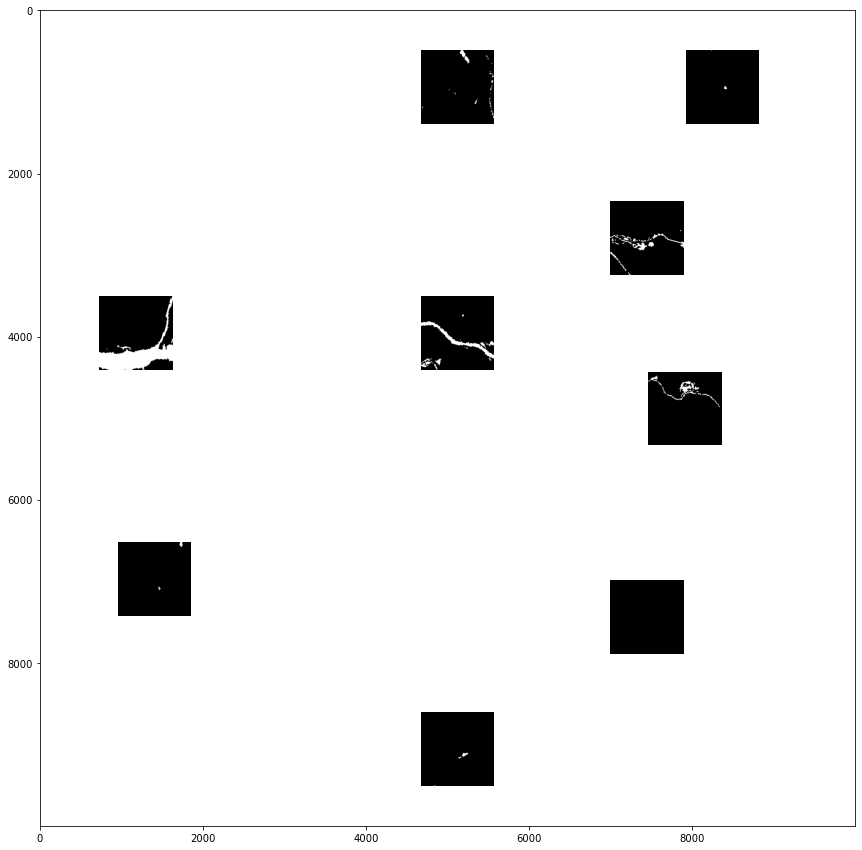

In [16]:
# An inspection of the validation sites within the region of interest

imgValid = constructImageFromPatches(images, target, imageType = "target", patchType = "valid")
plt.figure(figsize = (15, 15))
plt.imshow(imgValid, cmap='gray')
plt.show()

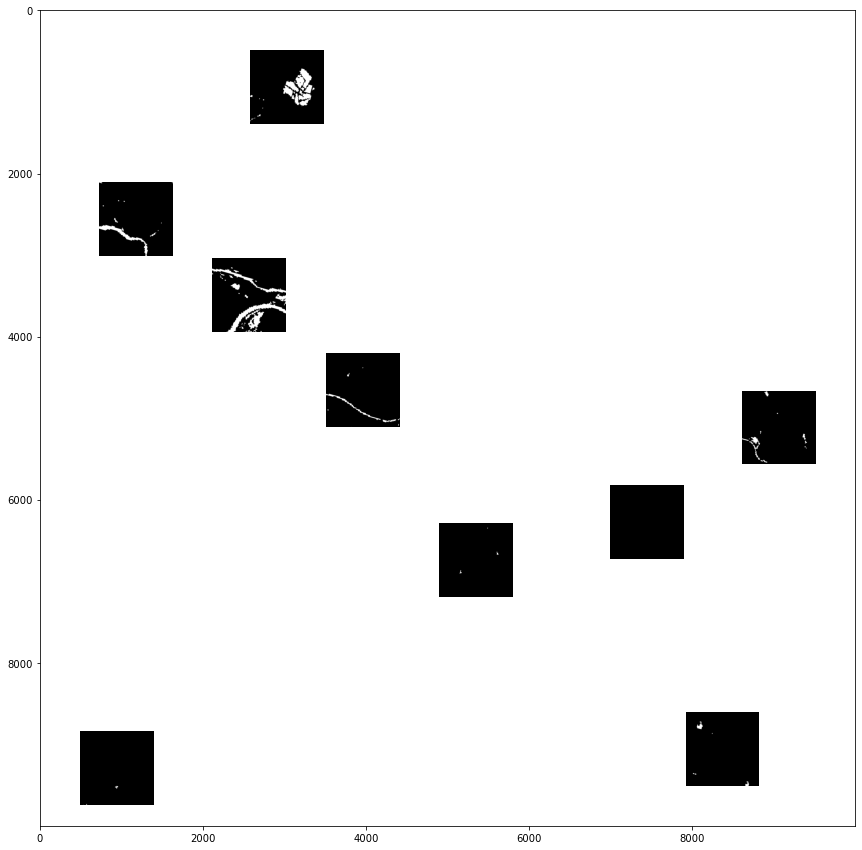

In [17]:
# An inspection of the testing sites within the region of interest

imgValid = constructImageFromPatches(images, target, imageType = "target", patchType = "test")
plt.figure(figsize = (15, 15))
plt.imshow(imgValid, cmap='gray')
plt.show()

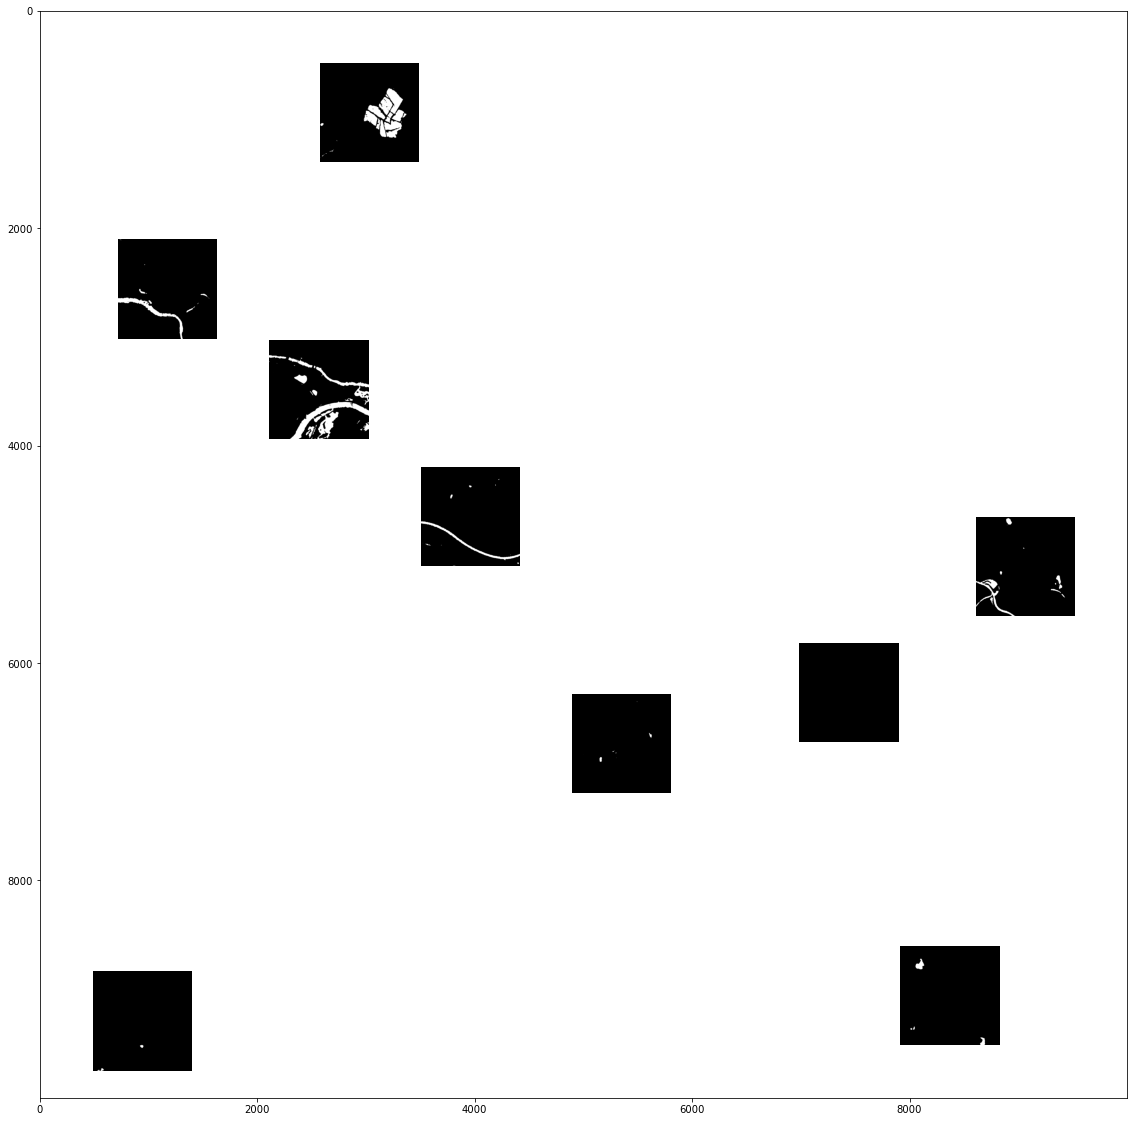

In [18]:
# An example for a relatively good prediction/segmentation 

res = constructImageFromPatches(images, target, imageType = "prediction", patchType = "test", imageIndex=18)
res = torch.sigmoid(torch.from_numpy(res).unsqueeze(0)).numpy().squeeze(0)
res[res < (0.5)] = 0
res[res >= (0.5)] = 1
plt.figure(figsize = (20,20))
plt.imshow(res, cmap='gray')
plt.show()

In [15]:
# Get ground thruth for testing sites

resTarget = constructImageFromPatches(images, target, imageType = "target", patchType = "test")

In [17]:
# A nice little loop to evaluate the model performance on all acquistions (and their testing rectangels)

prec = []
rec = []
f1 = []

for i in range(0, len(images)):
    res = constructImageFromPatches(images, target, imageType = "prediction", patchType = "test", imageIndex = i)
    res = torch.sigmoid(torch.from_numpy(res).unsqueeze(0)).numpy().squeeze(0)
    res[res < (0.5)] = 0
    res[res >= (0.5)] = 1
    
    precision = sum(sum((res==1) & (resTarget==1)))/sum(sum((res==1)))
    recall = sum(sum((res==1) & (resTarget==1)))/sum(sum((resTarget==1)))
    f1Score = 2*((precision*recall)/(precision+recall))
    
    prec.append(precision)
    rec.append(recall)
    f1.append(f1Score)
    
    print("Image Index: " + str(i))
    print("Precision: " + str(precision))
    print("Recall: " + str(recall))
    print("F1: " + str(f1Score))
    print("----------------")

Image Index: 0
Precision: 0.6224780531796469
Recall: 0.8473628886229015
F1: 0.7177168443815506
----------------
Image Index: 1
Precision: 0.8663873997291797
Recall: 0.41973575177239664
F1: 0.5655038028463847
----------------
Image Index: 2
Precision: 0.8647426807907248
Recall: 0.39773041156431266
F1: 0.5448582855521161
----------------
Image Index: 3
Precision: 0.7447045743945084
Recall: 0.8839924193597889
F1: 0.8083924768717483
----------------
Image Index: 4
Precision: 0.7507697981008574
Recall: 0.15620875916889176
F1: 0.258609903492866
----------------
Image Index: 5
Precision: 0.7715862469838395
Recall: 0.8759053801061903
F1: 0.8204430709524408
----------------
Image Index: 6
Precision: 0.7686799689622038
Recall: 0.7334844857747905
F1: 0.7506699149772376
----------------
Image Index: 7
Precision: 0.795943032858343
Recall: 0.7705743792775374
F1: 0.7830532922693073
----------------
Image Index: 8
Precision: 0.8143248532289629
Recall: 0.039909615443636255
F1: 0.07609009687718285
-----

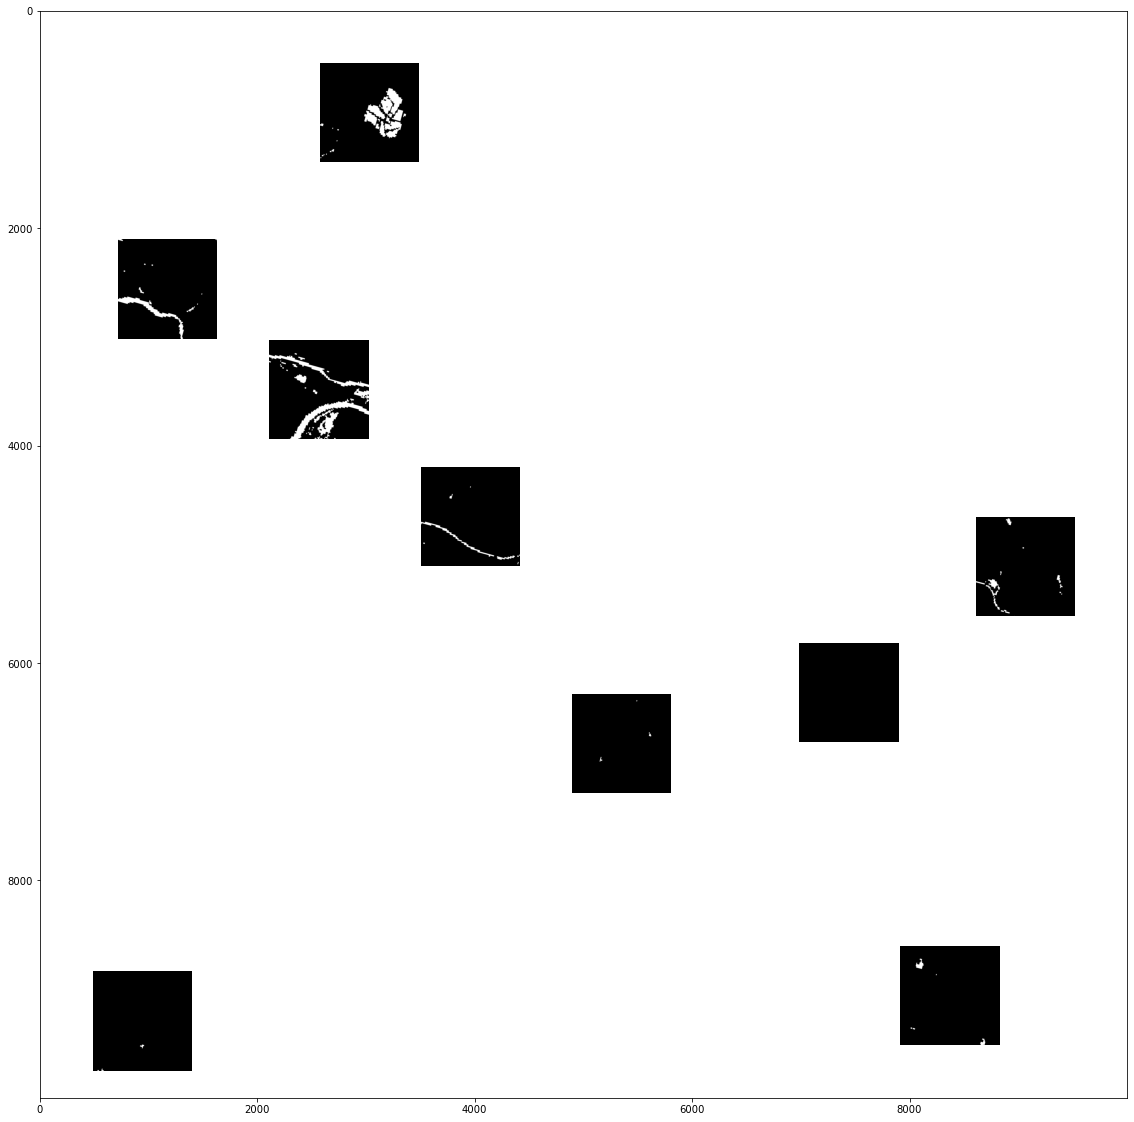

In [21]:
# Inspect testing target annotation

plt.figure(figsize = (20,20))
plt.imshow(resTarget, cmap='gray')
plt.show()

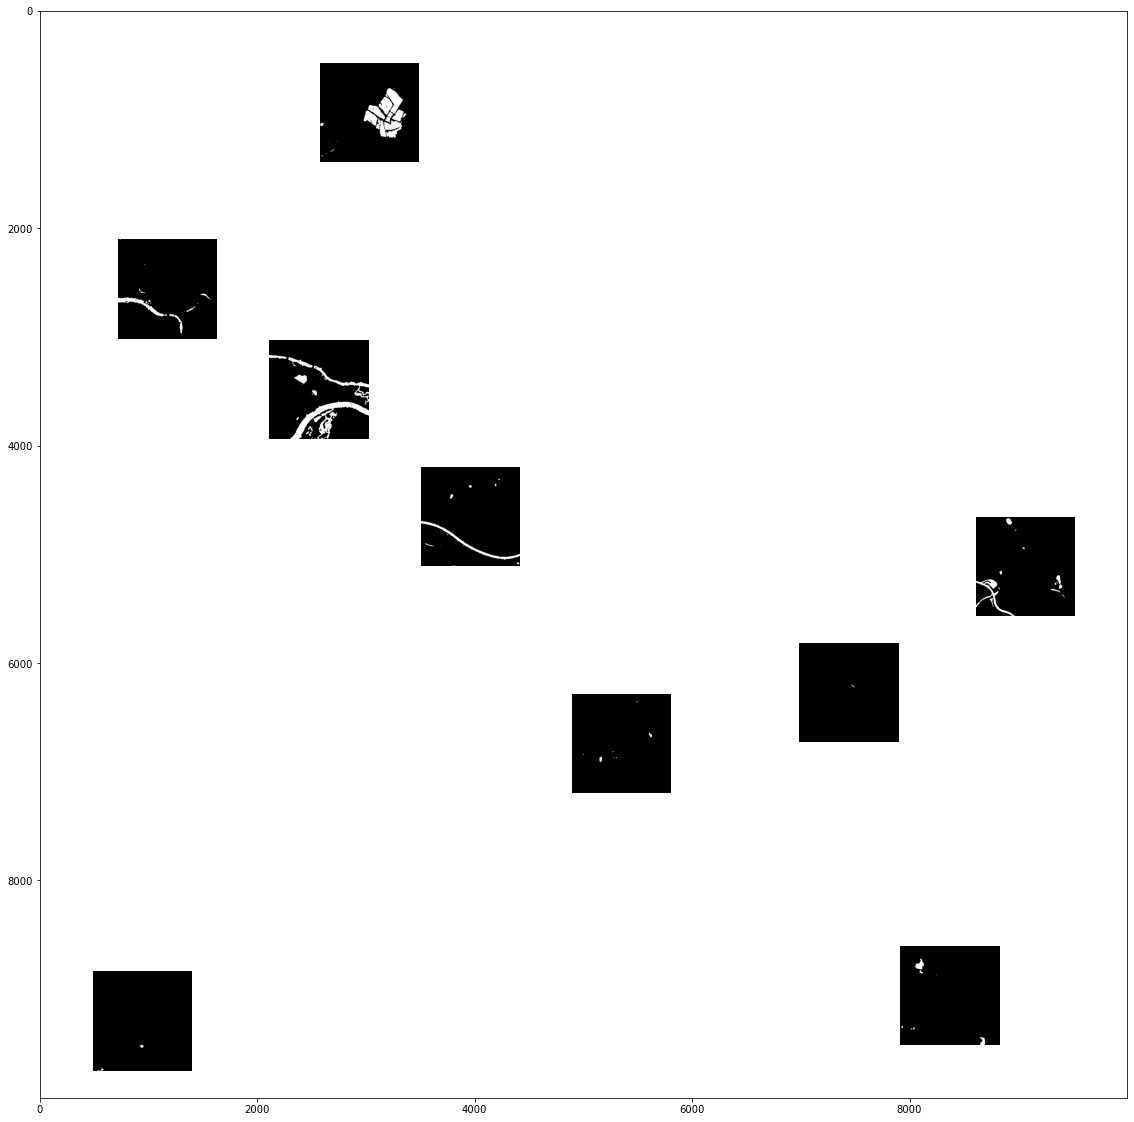

In [19]:
# An example for a relatively good prediction

resGoodPerf = constructImageFromPatches(images, target, imageType = "prediction", patchType = "test", imageIndex=15)
resGoodPerf = torch.sigmoid(torch.from_numpy(resGoodPerf).unsqueeze(0)).numpy().squeeze(0)
resGoodPerf[resGoodPerf < (0.5)] = 0
resGoodPerf[resGoodPerf >= (0.5)] = 1

plt.figure(figsize = (20,20))
plt.imshow(resGoodPerf, cmap='gray')
plt.show()

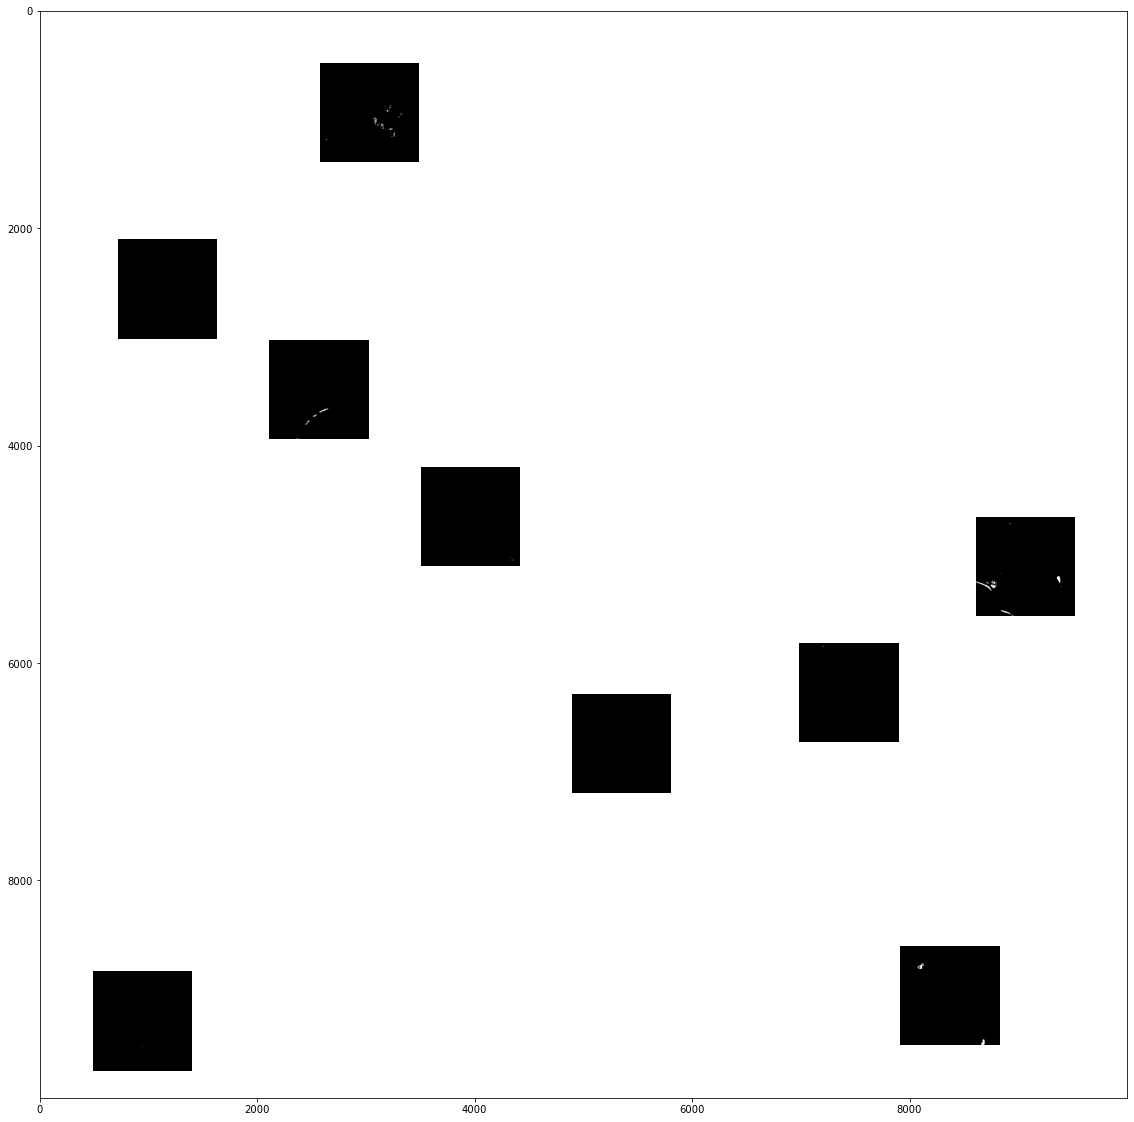

In [16]:
# An example for a bad prediction

resBadPerf = constructImageFromPatches(images, target, imageType = "prediction", patchType = "test", imageIndex=8)
resBadPerf = torch.sigmoid(torch.from_numpy(resBadPerf).unsqueeze(0)).numpy().squeeze(0)
resBadPerf[resBadPerf < (0.5)] = 0
resBadPerf[resBadPerf >= (0.5)] = 1
plt.figure(figsize = (20,20))
plt.imshow(resBadPerf, cmap='gray')
plt.show()

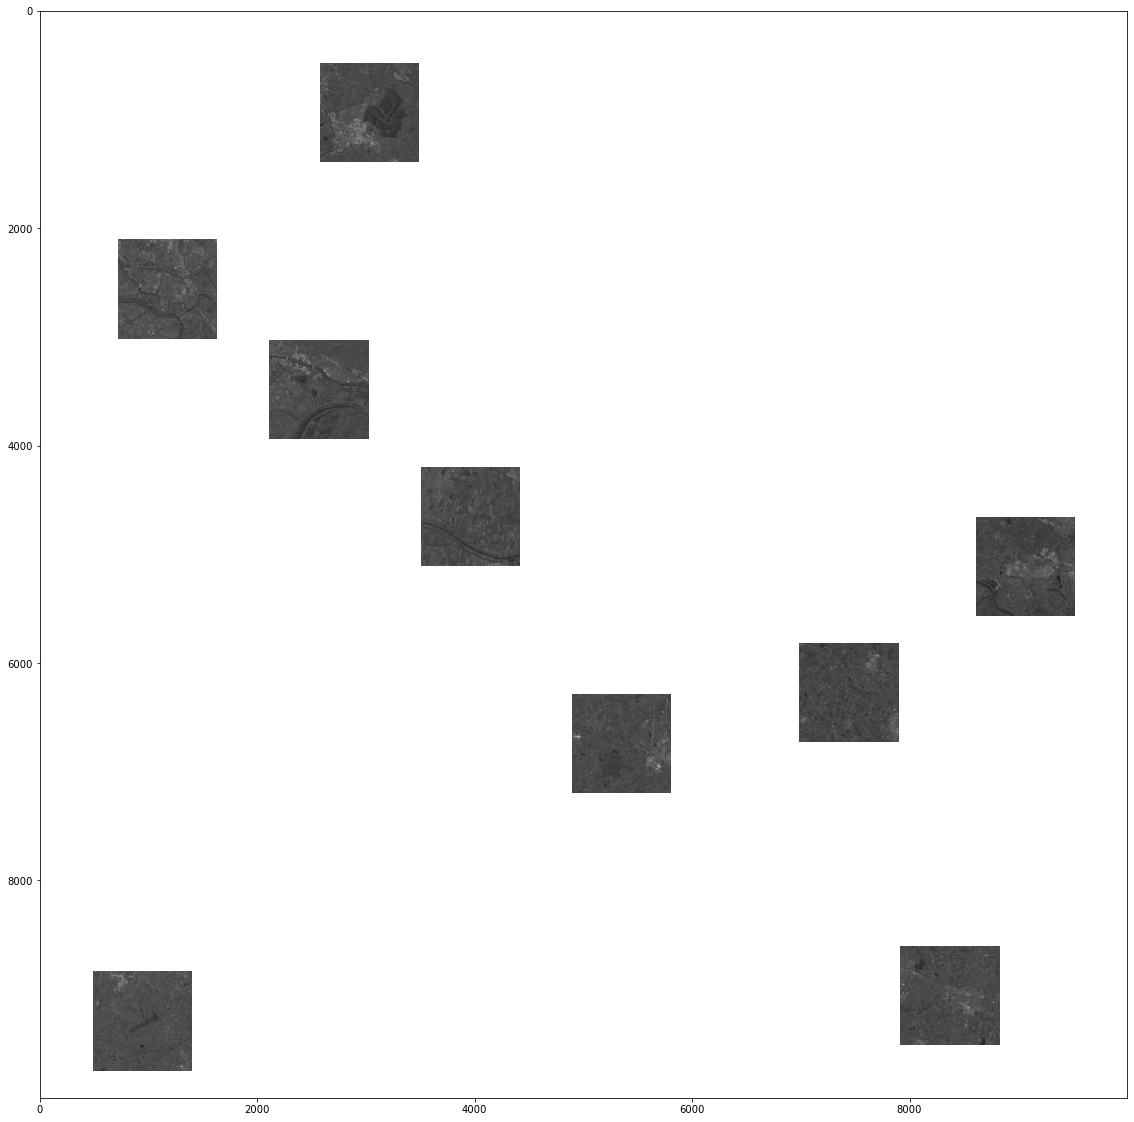

In [16]:
# Inspect possible reasons for the bad prediction above
resBadPerf = constructImageFromPatches(images, target, imageType = "original", patchType = "test", imageIndex=8)
plt.figure(figsize = (20,20))
plt.imshow(resBadPerf, cmap='gray')
plt.show()

In [17]:
# Extract only testing patches from the bad prediction above - aim to find better cut-off

model = GeoUNet(1).to("cuda")
model.load_state_dict(torch.load(os.path.join(home_path,'best_one.model'), map_location="cuda"))
model.eval()

patch_loader = torch.utils.data.DataLoader(GeoSet([images[8]], target, mode = "test"), shuffle=False)
indices = calc_patches(images, mode = "test")[0]

outputPatch = np.empty((len(indices)*256,256))
outputPatch[:] = np.NaN
targetPatch = np.empty((len(indices)*256,256))
targetPatch[:] = np.NaN

i = 0
with torch.no_grad():
    for index, (data, targetImage) in enumerate(patch_loader):
        data, targetImage = data.to("cuda", dtype=torch.float), targetImage.to("cuda", dtype=torch.float)
        output = model(data).cpu()
        outputPatch[(i*256):(i*256+256),:] = output
        targetPatch[(i*256):(i*256+256),:] = targetImage.cpu()
        i = i+1

In [18]:
# Apply sigmoid and turn into percentages for cut-off search
outputPatch = torch.sigmoid(torch.from_numpy(outputPatch).unsqueeze(0)).numpy().squeeze(0)

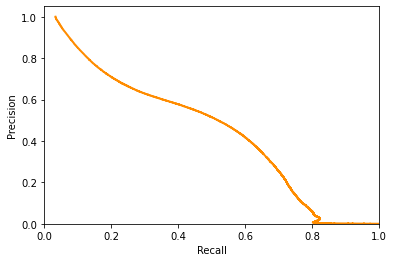

In [19]:
from sklearn.metrics import precision_recall_curve
pr, rc, thresholds = precision_recall_curve(targetPatch.astype("int").reshape(-1), outputPatch.reshape(-1))

plt.figure()
plt.plot(pr, rc, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [22]:
print("Possible better cut-off value index: " + str(np.argmin(np.abs((rc-0.5)))))

print("Balanced recall: " + str(rc[4705697]))
print("Balanced precision: " +  str(pr[4705697]))
print("Balanced threshold: " +  str(thresholds[4705697]))

Possible better cut-off value index: 4705697
Balanced recall: 0.5000015777798114
Balanced precision: 0.5188446324723633
Balanced threshold: 0.03131601790300821


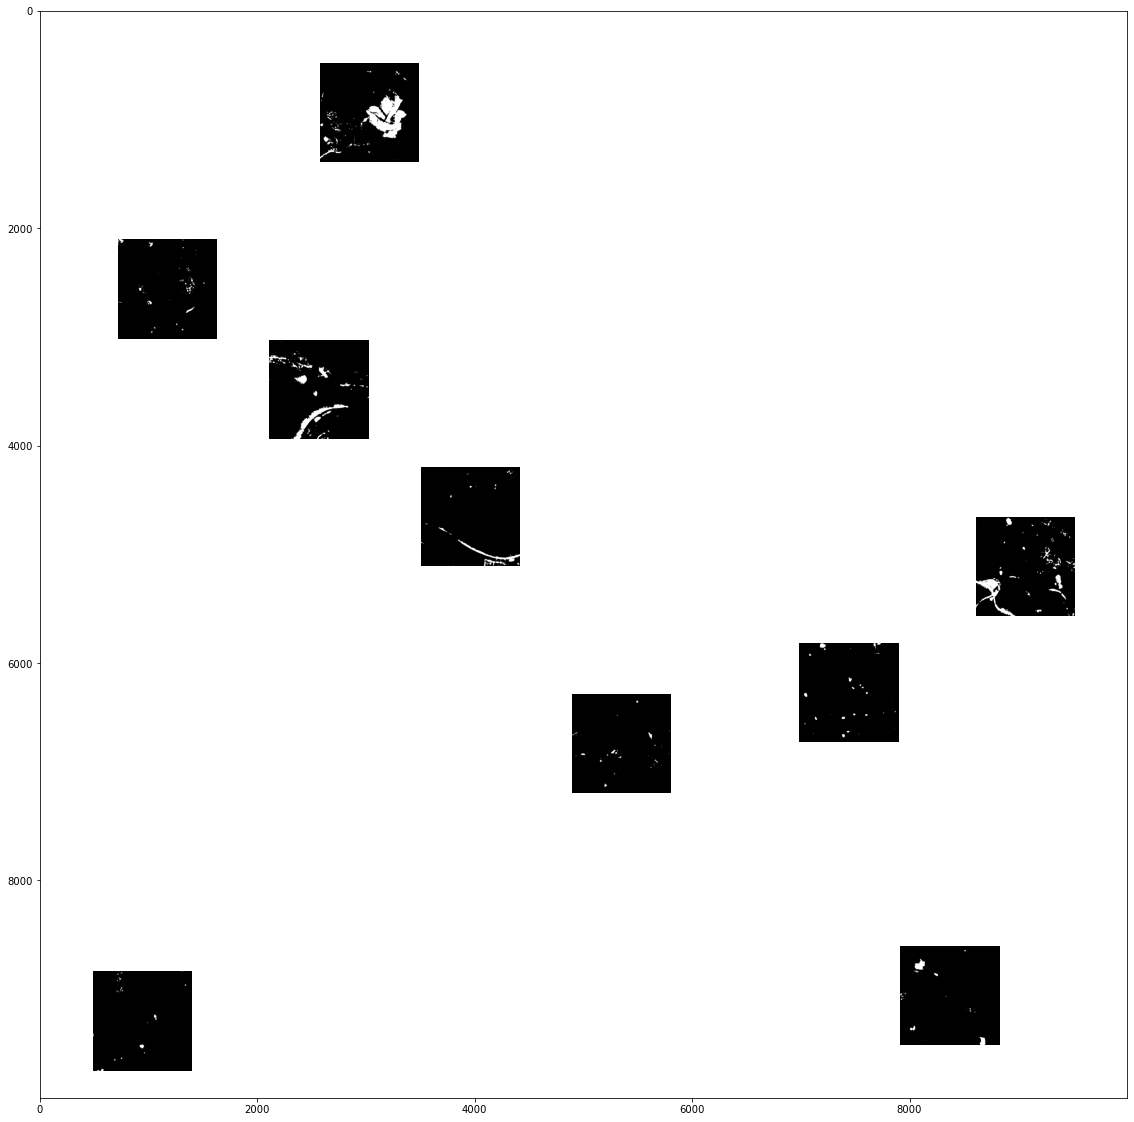

In [23]:
# Now inspect bad prediction with improved cut-off

resBadPerf = constructImageFromPatches(images, target, imageType = "prediction", patchType = "test", imageIndex=8)
res = resBadPerf.copy()
res = torch.sigmoid(torch.from_numpy(res).unsqueeze(0)).numpy().squeeze(0)
res[res < (0.032)] = 0
res[res >= (0.032)] = 1
plt.figure(figsize = (20,20))
plt.imshow(res, cmap='gray')
plt.show()

In [24]:
# Finally calculate its F1-Score

precision = sum(sum((res==1) & (resTarget==1)))/sum(sum((res==1)))
recall = sum(sum((res==1) & (resTarget==1)))/sum(sum((resTarget==1)))
2*((precision*recall)/(precision+recall))

0.5172178589452436

In [16]:
# Calculate aggregate prediction - by summing them up after cut-off with 0.5 (so sum up 0/1 prediction)

prediction_shape = np.empty((10000,10000))

for i in range(0, len(images)):
    pred = constructImageFromPatches(images, target, imageType = "prediction", patchType = "test", imageIndex=i)
    pred = torch.sigmoid(torch.from_numpy(pred).unsqueeze(0)).numpy().squeeze(0)
    pred[pred < (0.5)] = 0
    pred[pred >= (0.5)] = 1
    prediction_shape += pred

In [17]:
# Get the false positive predictions by adding the ground thruth to the aggreagate
# And just substracting all the area where the ground thruth contained water annotation

prediction_shape_cutout = prediction_shape.copy()
prediction_shape_cutout += (resTarget*51)
prediction_shape_cutout[prediction_shape_cutout > 50] = 0
prediction_shape_cutout = prediction_shape_cutout/np.nanmax(prediction_shape_cutout)

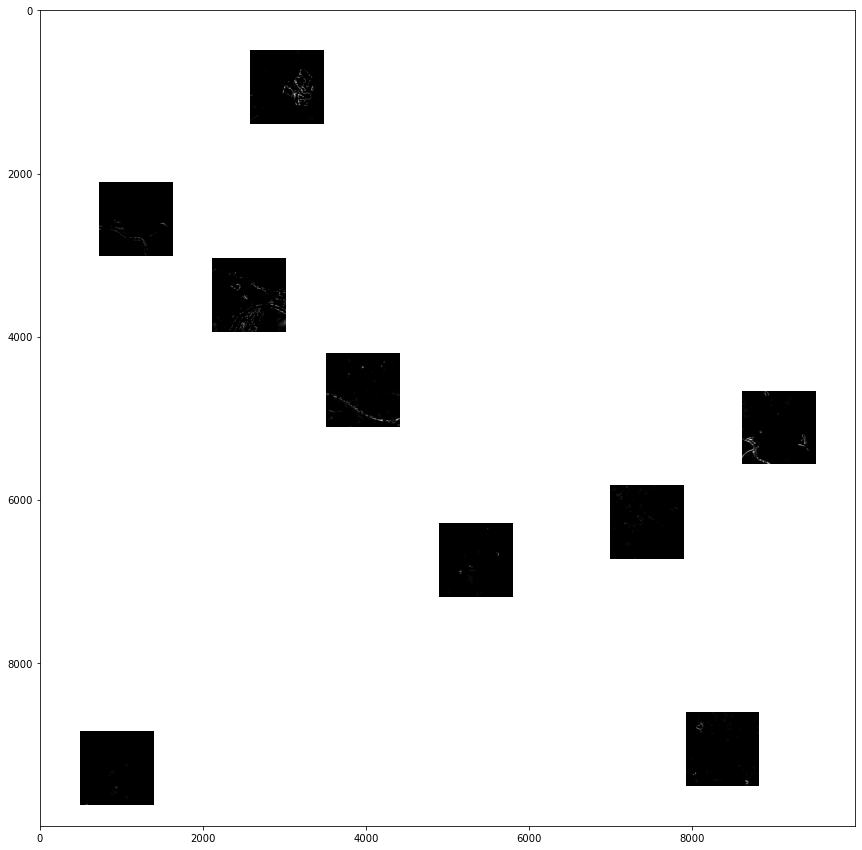

In [18]:
# Finally compare the mispredictions

plt.figure(figsize = (15,15))
plt.imshow(prediction_shape_cutout, cmap='gray', vmin=0, vmax = 1)
plt.show()

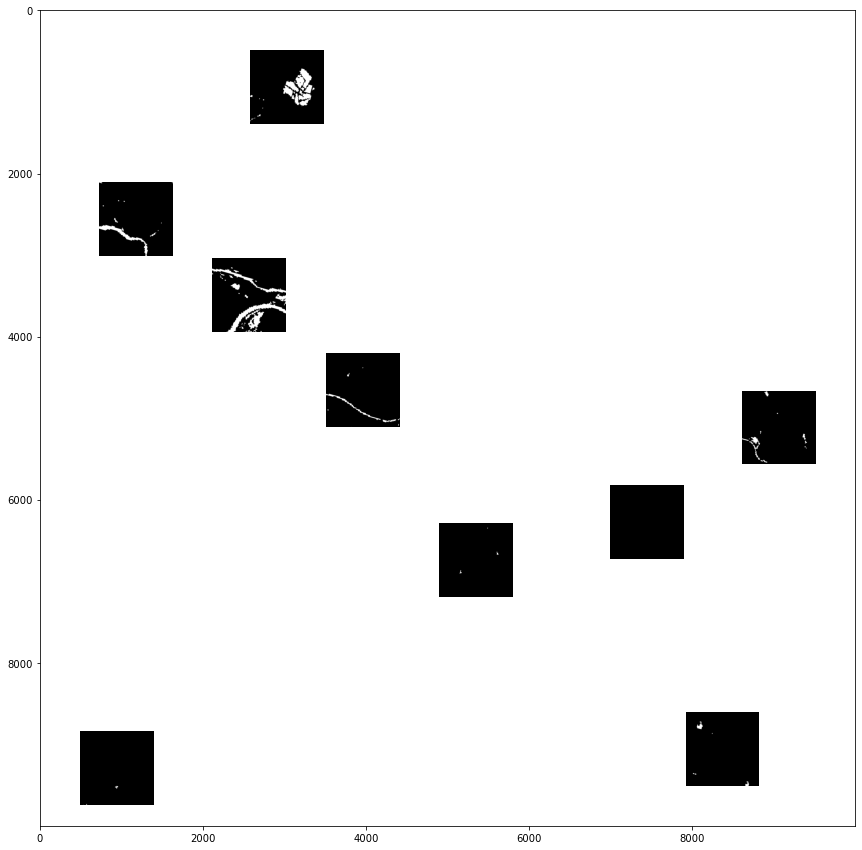

In [19]:
# With the ground thruth annotation

plt.figure(figsize = (15,15))
plt.imshow(resTarget, cmap='gray', vmin=0, vmax = 1)
plt.show()

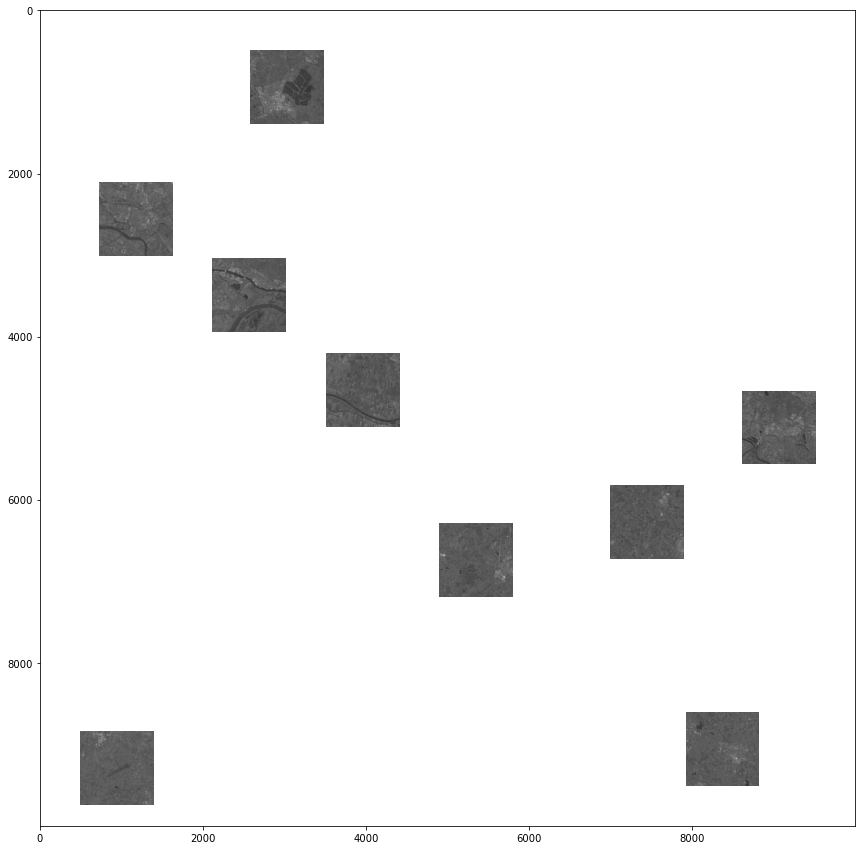

In [20]:
# As well as a sample iput image to see the differnces in the edges
# Note: High-resolution zoom was only available after downloading the images

origImage = constructImageFromPatches(images, target, imageType = "original", patchType = "test", imageIndex=20)
plt.figure(figsize = (15,15))
plt.imshow(origImage, cmap='gray')
plt.show()